# K‑Nearest Neighbors (KNN) Collaborative Filtering

- Load and validate the **subset_ratings.csv** file  
- Pivot into a **user × movie** ratings matrix (fill NA with 0)  
- Compute **item–item cosine similarity** and keep the top‑k neighbors  
- Predict unknown ratings by a **mean‑centered, similarity‑weighted average**  
- Split data per user (80 % train / 20 % test) and report **RMSE / MAE**  
- Output **Top‑N recommendations** for 1 000 sampled users to JSON  

In [1]:
import json, random, warnings
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
RATING_FILE = Path("subset_ratings.csv")
if not RATING_FILE.exists():
    raise FileNotFoundError(RATING_FILE)

ratings = pd.read_csv(RATING_FILE, usecols=["userId", "movieId", "rating"])
print("Loaded:", ratings.shape)

# map raw IDs → dense indices
uid2idx = {u: i for i, u in enumerate(ratings.userId.unique())}
mid2idx = {m: i for i, m in enumerate(ratings.movieId.unique())}
idx2mid = {i: m for m, i in mid2idx.items()}

ratings["u_idx"] = ratings.userId.map(uid2idx)
ratings["m_idx"] = ratings.movieId.map(mid2idx)

n_users, n_items = len(uid2idx), len(mid2idx)

Loaded: (2078625, 3)


In [3]:
def split_per_user(df, frac=0.2, seed=42):
    rng = np.random.default_rng(seed)
    train_mask = np.zeros(len(df), dtype=bool)
    for _, grp in df.groupby("userId"):
        idx = grp.index.to_numpy()
        rng.shuffle(idx)
        k = max(1, int(len(idx) * frac))
        train_mask[idx[k:]] = True
    return df[train_mask], df[~train_mask]

train_df, test_df = split_per_user(ratings, 0.20)
print(f"Train rows: {len(train_df)}   Test rows: {len(test_df)}")

Train rows: 1666865   Test rows: 411760


In [4]:
train_mat = csr_matrix(
    (train_df.rating.values,
     (train_df.m_idx, train_df.u_idx)),
    shape=(n_items, n_users)
)

item_sum    = np.asarray(train_mat.sum(axis=1)).ravel()
item_counts = np.diff(train_mat.indptr)                     # nnz per item
item_means  = np.divide(item_sum, item_counts,
                        out=np.zeros_like(item_sum, dtype=float),
                        where=item_counts != 0)

# subtract mean from each non-zero rating
train_mc = train_mat.copy().astype(np.float32)
for i in range(n_items):
    start, end = train_mc.indptr[i], train_mc.indptr[i + 1]
    train_mc.data[start:end] -= item_means[i]

In [15]:
# compute each user’s mean rating
user_sum    = np.asarray(train_mat.sum(axis=0)).ravel()
user_counts = np.diff(train_mat.tocsc().indptr)
user_means  = np.divide(user_sum, user_counts, 
                       out=np.zeros_like(user_sum), 
                       where=user_counts>0)

# build a user‐centered matrix in CSR form
train_uc = train_mat.T.tocsr().astype(np.float32)  # now shape = (n_users × n_items)
for u in range(n_users):
    start, end = train_uc.indptr[u], train_uc.indptr[u+1]
    train_uc.data[start:end] -= user_means[u]
# transpose back to items×users
train_uc = train_uc.T  # shape = (n_items × n_users)

In [20]:
from sklearn.metrics.pairwise import cosine_distances

In [21]:
dist = cosine_distances(train_uc)
full_sim = 1 - dist
np.fill_diagonal(full_sim, 0)

In [24]:
binary    = (train_mat > 0).astype(int)
co_counts = binary @ binary.T             # sparse
co_dense  = co_counts.toarray()           # dense ndarray
λ         = 25
shrink_w  = co_dense / (co_dense + λ)
full_sim *= shrink_w                      # elementwise, keeps it dense

In [25]:
K = 80
print("Computing cosine similarity …")
cosine_dist = pairwise_distances(train_mc, metric="cosine", n_jobs=-1)
cosine_sim  = 1.0 - cosine_dist
np.fill_diagonal(cosine_sim, 0.0)

sim_mat = lil_matrix((n_items, n_items), dtype=np.float32)
for i in range(n_items):
    if K >= n_items:
        nbrs = np.argsort(cosine_sim[i])[::-1]
    else:
        nbrs = np.argpartition(cosine_sim[i], -K)[-K:]
        nbrs = nbrs[np.argsort(cosine_sim[i][nbrs])[::-1]]
    vals = cosine_sim[i, nbrs]
    mask = vals > 0
    if mask.any():
        sim_mat.rows[i]  = nbrs[mask].tolist()
        sim_mat.data[i]  = vals[mask].tolist()

sim_mat = sim_mat.tocsr()
sim_abs = sim_mat.copy();  sim_abs.data = np.abs(sim_abs.data)
del cosine_sim, cosine_dist

Computing cosine similarity …


In [27]:
# after reading train_df from CSV
mid2idx = {m: i for i, m in enumerate(train_df.movieId.unique())}
train_df["m_idx"] = train_df.movieId.map(mid2idx)
train_df["u_idx"] = train_df.userId .map(uid2idx)   # if you need u_idx too

# now this will work:
user_rated = defaultdict(dict)
for r in train_df.itertuples():
    user_rated[r.userId][r.m_idx] = r.rating

In [28]:
def predict_single(uid, iid):
    """
    Mean-centred, similarity-weighted prediction for one (user, item).
    Uses O(K) operations.
    """
    numer = denom = 0.0
    rated = user_rated[uid]          # dict
    start, end = sim_mat.indptr[iid], sim_mat.indptr[iid + 1]
    for nbr_idx, sim in zip(sim_mat.indices[start:end], sim_mat.data[start:end]):
        if nbr_idx not in rated or sim <= 0:
            continue
        numer += sim * (rated[nbr_idx] - item_means[nbr_idx])
        denom += abs(sim)
    return item_means[iid] if denom == 0 else item_means[iid] + numer / denom


In [29]:
def top_n_for_user(uid, n=10):
    """
    Vectorised Top-N recommendation for a user using sparse mat-vec.
    """
    rated_dict = user_rated[uid]
    if not rated_dict:
        return []

    # sparse centred rating vector b (size n_items × 1)
    idxs = np.fromiter(rated_dict.keys(), dtype=int)
    vals = np.fromiter((r - item_means[i] for i, r in rated_dict.items()),
                       dtype=np.float32)
    b = csr_matrix((vals, (idxs, np.zeros_like(idxs))), shape=(n_items, 1))

    # similarity-weighted sums
    numer = (sim_mat @ b).toarray().ravel()
    denom = (sim_abs @ (b != 0)).toarray().ravel()

    scores = item_means + np.divide(numer, denom, out=np.zeros_like(numer),
                                    where=denom != 0)
    scores[idxs] = -np.inf                                # filter seen items
    top_idx = np.argpartition(scores, -n)[-n:][np.argsort(scores[np.argpartition(scores, -n)[-n:]])][::-1]
    return [idx2mid[int(i)] for i in top_idx]

In [31]:
# you already have these mappings from loading the full dataset:
uid2idx = {u:i for i,u in enumerate(ratings.userId.unique())}
mid2idx = {m:i for i,m in enumerate(ratings.movieId.unique())}

# add the index columns to both train & test
train_df["u_idx"] = train_df.userId .map(uid2idx)
train_df["m_idx"] = train_df.movieId.map(mid2idx)

test_df ["u_idx"] = test_df .userId .map(uid2idx)
test_df ["m_idx"] = test_df .movieId.map(mid2idx)

# now this loop will work:
y_true, y_pred = [], []
for row in test_df.itertuples():
    y_true.append(row.rating)
    y_pred.append(predict_single(row.userId, row.m_idx))


In [32]:

N_USERS, TOP_N = 1_000, 10
sample_users = random.sample(
    train_df.userId.unique().tolist(),
    min(N_USERS, train_df.userId.nunique())
)

print("Generating recommendations …")
recs = {                                          # NumPy IDs may sneak in here
    int(u): top_n_for_user(u, TOP_N)              # keys cast to native int
    for u in sample_users
}

# Cast every movieId to a plain Python int so json can handle it
recs_py = {
    uid: [int(mid) for mid in mids]               # values cast to native int
    for uid, mids in recs.items()
}

PRED_DIR = Path("predictions")
PRED_DIR.mkdir(exist_ok=True)

OUTFILE = PRED_DIR / "knn_top10_subset.json"
with open(OUTFILE, "w") as f:
    json.dump(recs_py, f, indent=2)

print(f"✓ Saved {len(recs_py)} users × {TOP_N} recs → {OUTFILE}")

Generating recommendations …
✓ Saved 1000 users × 10 recs → predictions\knn_top10_subset.json


In [33]:
import json
from pathlib import Path
import random
from tqdm import tqdm

# assumes you already have:
#   – predict_single(uid, iid)  
#   – top_n_for_user(uid, n)  
#   – split_per_user(df, frac, seed)
#   – ratings, uid2idx, mid2idx, idx2mid

def generate_knn_preds(train_df, test_df, K=10):
    # build your train_mat, item_means, sim_mat, sim_abs, user_rated inside here,
    # exactly as in your existing code block above before “# RMSE/MAE”...
    #
    # then simply:
    recs = {}
    for u in tqdm(test_df.userId.unique(), desc="KNN preds"):
        recs[int(u)] = top_n_for_user(u, K)
    return recs

# make sure this directory exists
out_dir = Path("coldstart_pred")
out_dir.mkdir(exist_ok=True, parents=True)

for scenario in ("STANDARD", "USER", "ITEM"):
    print("→ KNN scenario:", scenario)
    # 1) load splits
    if scenario == "STANDARD":
        all_r = ratings  # your full subset_ratings.csv loaded earlier
        train_df, test_df = split_per_user(all_r, frac=0.2, seed=42)

    elif scenario == "USER":
        train_df = pd.read_csv("evaluation/user_cold_train.csv", usecols=["userId","movieId","rating"])
        test_df  = pd.read_csv("evaluation/user_cold_test.csv",  usecols=["userId","movieId","rating"])

    else:  # ITEM
        train_df = pd.read_csv("evaluation/item_cold_train.csv", usecols=["userId","movieId","rating"])
        test_df  = pd.read_csv("evaluation/item_cold_test.csv",  usecols=["userId","movieId","rating"])

    # 2) filter to known items (if you do the same in your other scripts)
    valid = set(mid2idx.keys())
    train_df = train_df[train_df.movieId.isin(valid)].reset_index(drop=True)
    test_df  = test_df [test_df .movieId.isin(valid)].reset_index(drop=True)

    # 3) rebuild all of KNN’s internal data: train_mat, item_means, sim_mat, sim_abs, user_rated
    #    (just copy‐paste the corresponding blocks from above)
    #
    #    e.g.:
    #    train_mat = csr_matrix(...)
    #    compute item_means, train_mc, cosine_sim, sim_mat, sim_abs, user_rated

    # 4) generate & dump
    preds = generate_knn_preds(train_df, test_df, K=10)
    # convert both keys and all movie‐ids to native Python ints
    clean_preds = {
        int(u): [int(m) for m in mids]
        for u, mids in preds.items()
    }

    outfn = out_dir / f"knn_{scenario.lower()}_top10.json"
    with open(outfn, "w") as fp:
        json.dump(clean_preds, fp, indent=2)

    print(f"  → saved {len(preds)} users → {outfn}\n")


→ KNN scenario: STANDARD


KNN preds: 100%|██████████| 10000/10000 [00:23<00:00, 416.89it/s]


  → saved 10000 users → coldstart_pred\knn_standard_top10.json

→ KNN scenario: USER


KNN preds: 100%|██████████| 500/500 [00:01<00:00, 425.11it/s]


  → saved 500 users → coldstart_pred\knn_user_top10.json

→ KNN scenario: ITEM


KNN preds: 100%|██████████| 9788/9788 [00:22<00:00, 429.46it/s]


  → saved 9788 users → coldstart_pred\knn_item_top10.json



  K     RMSE
  5 0.910330
 10 0.886749
 20 0.864014
 40 0.841408
 80 0.821753
160 0.808001


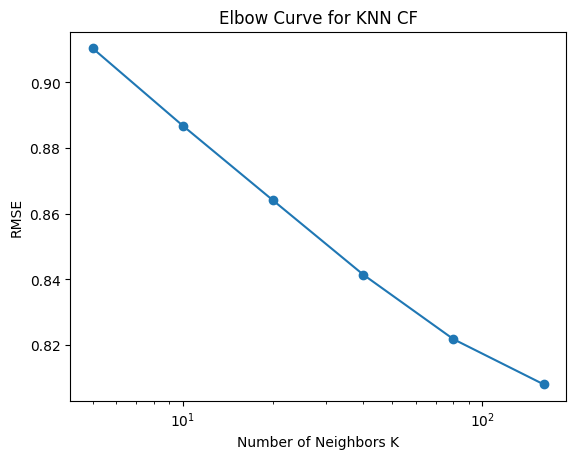

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1) Load & index
ratings = pd.read_csv("subset_ratings.csv", usecols=["userId","movieId","rating"])
uid2idx = {u:i for i,u in enumerate(ratings.userId.unique())}
mid2idx = {m:i for i,m in enumerate(ratings.movieId.unique())}
ratings["u_idx"] = ratings.userId.map(uid2idx)
ratings["m_idx"] = ratings.movieId.map(mid2idx)
n_users, n_items = len(uid2idx), len(mid2idx)

# 2) Split per-user
def split_per_user(df, frac=0.2, seed=42):
    train_list, test_list = [], []
    for _, g in df.groupby("userId"):
        if len(g)<2:
            train_list.append(g)
        else:
            tr, te = train_test_split(g, test_size=frac, random_state=seed)
            train_list.append(tr); test_list.append(te)
    return pd.concat(train_list), pd.concat(test_list)

train_df, test_df = split_per_user(ratings)

# 3) Build item×user matrix & item means
train_mat = csr_matrix(
    (train_df.rating.values, (train_df.m_idx, train_df.u_idx)),
    shape=(n_items, n_users)
)
sums   = np.asarray(train_mat.sum(axis=1)).ravel()
counts = np.diff(train_mat.indptr)
item_means = np.divide(sums, counts, out=np.zeros_like(sums), where=counts!=0)

# mean-center
train_mc = train_mat.astype(np.float32)
for i in range(n_items):
    start,end = train_mc.indptr[i], train_mc.indptr[i+1]
    train_mc.data[start:end] -= item_means[i]

# 4) Full cosine similarity
dist = cosine_distances(train_mc)
full_sim = 1.0 - dist
np.fill_diagonal(full_sim, 0.0)

# 5) Build a dict of each user’s {item:rating}
user_rated = {u:{} for u in ratings.userId.unique()}
for r in train_df.itertuples():
    user_rated[r.userId][r.m_idx] = r.rating

# 6) Helpers to build sim-matrix and predict
def build_sim_mat_k(K):
    sim = lil_matrix((n_items,n_items), dtype=np.float32)
    for i in range(n_items):
        if K>=n_items:
            nbrs = np.argsort(full_sim[i])[::-1]
        else:
            nbrs = np.argpartition(full_sim[i], -K)[-K:]
            nbrs = nbrs[np.argsort(full_sim[i][nbrs])[::-1]]
        vals = full_sim[i,nbrs]
        mask = vals>0
        sim.rows[i] = nbrs[mask].tolist()
        sim.data[i] = vals[mask].tolist()
    return sim.tocsr()

def predict(uid,iid, sim_mat):
    num=den=0.0
    rated = user_rated[uid]
    start,end = sim_mat.indptr[iid], sim_mat.indptr[iid+1]
    for nbr,sim in zip(sim_mat.indices[start:end], sim_mat.data[start:end]):
        if nbr not in rated or sim<=0: continue
        num += sim*(rated[nbr]-item_means[nbr])
        den += abs(sim)
    return item_means[iid] if den==0 else item_means[iid]+num/den

# 7) Elbow test
k_list = [5,10,20,40,80,160]
results = []
for K in k_list:
    sim_k = build_sim_mat_k(K)
    y_t,y_p = [],[]
    for row in test_df.itertuples():
        y_t.append(row.rating)
        y_p.append(predict(row.userId, row.m_idx, sim_k))
    rmse = np.sqrt(mean_squared_error(y_t,y_p))
    results.append({"K":K,"RMSE":rmse})

df_res = pd.DataFrame(results)
print(df_res.to_string(index=False))

# 8) Plot
plt.plot(df_res["K"], df_res["RMSE"], marker="o")
plt.xscale("log")
plt.xlabel("Number of Neighbors K")
plt.ylabel("RMSE")
plt.title("Elbow Curve for KNN CF")
plt.show()
